### Load necessary packages

In [1]:
import numpy as np  
from math import sin, cos, pi, log, exp, sqrt  

import matplotlib.pyplot as plt  # Plotting and visualization
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting support
from matplotlib.ticker import FuncFormatter  # Custom formatting for axis ticks
from matplotlib.lines import Line2D  # Custom line objects for legends
import pandas as pd

import qGP_DRT as qGP  # Custom module for qGP DRT analysis
import importlib  
import generate_data as data  

# Reload custom modules to ensure the latest changes are used

importlib.reload(data)
importlib.reload(qGP)

<module 'qGP_DRT' from 'C:\\Users\\user\\Desktop\\qGP\\qGP-DRT\\tutorials\\qGP_DRT.py'>

### 1) Experimental state

In [2]:
cycle_min = 30
cycle_max = 120
delta_T = 30
cycle_range = np.arange(cycle_min, cycle_max+delta_T, delta_T)
if cycle_min == cycle_max:
    cycle_range_norm = np.array([0.0])
else:
    cycle_range_norm = (cycle_range-cycle_min)/(cycle_max-cycle_min)

N_cycles = len(cycle_range)

#### 1.1) Load experimental data

In [3]:
N_psi = (len(cycle_range))
Z_exp_re = [0]*N_psi
Z_exp_im = [0]*N_psi
freqvec = [0]*N_psi

for k in range(N_cycles):
    
    cycle = cycle_range[k] 
    
    df = pd.read_csv('./experimental_data/LFP/LFP_cycle'+str(cycle)+'.csv')
    freqvec[k], N_taus = df['Freq'].values, df['Freq'].size
    freq_vec = df['Freq'].values
    N_freqs  = freq_vec.size
    
    # experimental impedance
    Z_exp_re[k] = (df['Real'].values)
    Z_exp_im[k] = (-df['Imag'].values)

#### 1.2) Define frequency range

In [4]:
# define frequency range
log_freq_min = -2.
log_freq_max = 8.

# define tau range (as in previous papers tau=1/f)
log_tau_min = -8.  # -6
log_tau_max = 2.   # 6

N_psi = N_cycles
_, tau_vecs, log_tau_vecs = \
data.generate_freq_and_tau_vec(N_psi,N_freqs, N_taus, log_freq_min, log_freq_max, log_tau_min, log_tau_max)

tau_vec = tau_vecs[0]

log_tau_vec = log_tau_vecs[0]

## For plotting only
freq_vec_plot = np.logspace(log_freq_min, log_freq_max, num = 10*(N_freqs-1), endpoint=True)
tau_vec_plot = np.logspace(log_tau_min, log_tau_max, num = 10*(N_taus-1), endpoint=True)
log_tau_vec_plot = np.log(tau_vec)

#### 1.3) Stack the generated experimental impedance

In [5]:
Z_exp_re_im = qGP.create_Z_exp_re_im(Z_exp_re, Z_exp_im, N_freqs)

#### 1.4) Compute discretization matrix for all experiments

In [6]:
freq_vecs = [freqvec[k] for k in range(N_psi)]
A_exp = qGP.compute_A_exp(freq_vecs,tau_vecs,N_psi)

#### 1.5) Initial guess for the hyperparameter

In [7]:
sigma_n_exp = 0.5
sigma_n = 0.5
sigma_R = 9.5
sigma_L = 9.6
sigma_k = 7.0
l_f = 0.95
l_psi = 0.94
l_R = 0.94

## 
theta_0 = np.array([sigma_n,sigma_R, sigma_k, l_f, l_psi, l_R])

#### 1.6) DRT deconvolution

In [8]:
elapsed_time, samples_raw = qGP.sample_DRT(theta_0, A_exp, Z_exp_re_im, N_freqs, log_tau_vec, cycle_range, N_psi)

sigma_n, sigma_R, sigma_k, l_f, l_psi, l_R
0.3000000 9.9765739 5.7572632 1.0000000 0.9311346 0.9390120
0.3002520 9.9995183 6.2353696 0.9999484 1.0000000 1.0000000
0.3000000 10.0000000 6.9881774 1.0000000 0.8000351 0.3842240
0.3000000 10.0000000 6.4732031 1.0000000 0.8001778 0.7939366
0.3002670 9.9994241 6.1109362 0.9999454 0.8000000 0.4489676
Optimization terminated successfully    (Exit mode 0)
            Current function value: 128.66553655251636
            Iterations: 5
            Function evaluations: 47
            Gradient evaluations: 5


Sampling from truncated multivariate normal using Hamiltonian Monte Carlo.....


Current sample number 1000 / 10000
Current sample number 2000 / 10000
Current sample number 3000 / 10000
Current sample number 4000 / 10000
Current sample number 5000 / 10000
Current sample number 6000 / 10000
Current sample number 7000 / 10000
Current sample number 8000 / 10000
Current sample number 9000 / 10000
Current sample number 10000 / 10000


In [9]:
elapsed_time/60

3.98402380545934

#### 1.7) Extract recovered DRT and its credible bands

In [10]:
gamma_median, gamma_upper, gamma_lower = qGP.gamma_results(N_taus, samples_raw, N_psi)

#### 1.8) Extract recovered impedance with its credible bands

In [11]:
Z_re_median, Z_im_median, Z_re_upper, Z_im_upper, Z_re_lower, Z_im_lower = \
qGP.recovered_impedances(N_freqs, samples_raw, A_exp, N_psi)

### 2) DRTtools and ECM Results

#### 2.1) Load the DRTs and impedances recoverd with DRTtools

In [12]:
DRTtools = np.load('./DRTtools/gamma_DRTtools_.npy')
tau_DRTtools = np.load('./DRTtools/tau_DRTtools.npy')
Z_re_DRTtools = np.load('./DRTtools/Zre_DRTtools.npy')
Z_im_DRTtools = np.load('./DRTtools/Zim_DRTtools.npy')

Z_DRTtools = [Z_re_DRTtools[k] + 1j*Z_im_DRTtools[k] for k in range(N_psi)]

#### 2.2) ECM and impedance

In [13]:
gamma_ECM = np.load('./ECM/gamma_ECM.npy')
Z_ECM_re = np.load('./ECM/Z_ECM_re.npy')
Z_ECM_im = np.load('./ECM/Z_ECM_im.npy')
tau_ECM = np.load('./ECM/tau_ECM.npy')

Z_ECM = [Z_ECM_re[k]+1j*Z_ECM_im[k] for k in range(N_psi)]

#### 2.3) Nyquist plot corresponding to panel (b) of Figure 6 in the main article

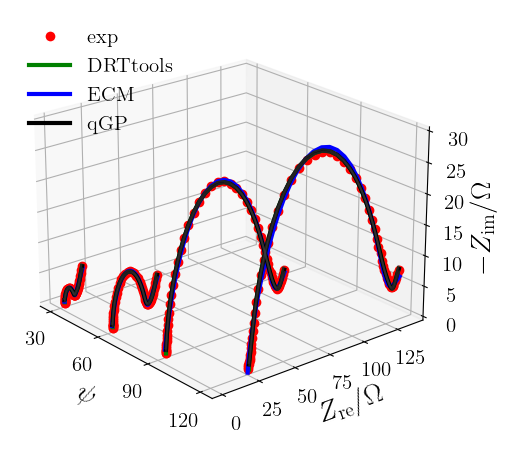

In [15]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# preprocessing
Z_exp = [Z_exp_re[k] + 1j*Z_exp_im[k] for k in range(N_psi)]
Z_median = [Z_re_median[k] + 1J*Z_im_median[k] for k in range(N_psi)]
Z_upper = [Z_re_upper[k] + 1j*Z_im_upper[k] for k in range(N_psi)]
Z_lower = [Z_re_lower[k] + 1j*Z_im_lower[k] for k in range(N_psi)]

# experimental state (i.e., cycle numbers)

cycles = ["30", "60", "90", "120"]

# create a 3D-like figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

legend_elements = []  # List to store custom legend handles and labels

# plot the experimental data (Z_exp)
for k, Za in enumerate(Z_exp):
    ax.plot(np.full(len(Za), k), Za.real, -Za.imag, 'o', color='red')
    
# plot the DRTtools impedance (Z_DRTtools)
for k, Zb in enumerate(Z_DRTtools):
    ax.plot(np.full(len(Zb), k), Zb.real, -Zb.imag, linewidth=3, color='green')

# plot the ECM impedance (Z_ECM)
for k, Zc in enumerate(Z_ECM):
    ax.plot(np.full(len(Zc), k), Zc.real, -Zc.imag, linewidth=3, color='blue')

# plot the recovered imepdance (Z_median)
for k, Z_val in enumerate(Z_median):
    ax.plot(np.full((Z_val.shape), k), Z_val.real, -Z_val.imag, linewidth=3, color='black')

# add credible bands
for k, (Zu, Zl) in enumerate(zip(Z_upper, Z_lower)):
    ax.plot(np.full(len(Zu), k), Zu.real, -Zu.imag, alpha=0.5, color='0.25')
    ax.plot(np.full(len(Zl), k), Zl.real, -Zl.imag, alpha=0.5, color='0.25')
    
# add legend handles and labels
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='exp', markerfacecolor = 'red' , markersize=8))
legend_elements.append(Line2D([0], [0], color='green', lw=3, label='DRTtools'))
legend_elements.append(Line2D([0], [0], color='blue', lw=3, label='ECM'))
legend_elements.append(Line2D([0], [0], color='black', lw=3, label='qGP'))

# add X- and Z-axis labels
ax.set_xlabel(r'$\psi$', fontsize=20, labelpad=6)
ax.set_ylabel(r'$Z_{\rm re}/\Omega$', fontsize=20, labelpad=5)

# set X-ticks and labels
ax.set_xticks(range(len(cycles)))
ax.set_xticklabels(cycles)
# set Z-axis limits
ax.set_zlim(0, 30)

# show the custom legend with specified colors
ax.legend(handles=legend_elements, loc='upper left', frameon=False)

# adjust the view angle
ax.view_init(elev=22, azim=-40)
ax.text2D(1.07, 0.40, r'$-Z_{\rm im}/\Omega$', transform=ax.transAxes, fontsize=20,rotation=90)

# adjust figure size
fig.set_size_inches(5.572, 5.572)

plt.show()


#### 2.4) Nyquist plot corresponding to panel (d) of Figure 6 in the main article

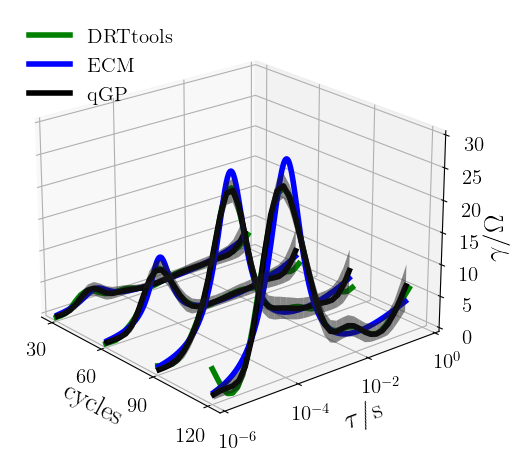

In [16]:
# experimental state (cycles number)
cycles = ["30", "60", "90", "120"]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for k in range(len(cycles)):
    ax.plot(np.full(len(tau_DRTtools), k), np.log10(tau_DRTtools), DRTtools[k], linewidth=4, color='green')
    ax.plot(np.full(len(tau_ECM), k), np.log10(tau_ECM), gamma_ECM[k], linewidth=4, color='blue')
    ax.plot(np.full(len(tau_vecs[0][12:-15]), k), np.log10(tau_vecs[0][12:-15]), gamma_median[k][12:-15], linewidth=4, color='black')
    
    # surface plot
    ax.plot_surface(np.full((tau_vecs[0][12:-15]).shape, k),np.log10(tau_vecs[0][12:-15]),np.vstack((gamma_lower[k][12:-15], gamma_upper[k][12:-15])),
        rstride=1, cstride=1, alpha=0.5, color='0.25'
    )

# set axes labels
ax.set_xlabel(r'$\rm cycles$', fontsize=20)
ax.set_ylabel(r'$\tau/\rm s$', fontsize=20)

# adjust Z-axis 
ax.set_zlim3d(0, 30)
ax.view_init(elev=22, azim=-40)

# set X-axis ticks and labels
ax.set_xticks(range(len(cycles)))
ax.set_xticklabels(cycles)

# custom Y-axis tick formatter
def format_y_ticks(tick_val, tick_pos):
    if int(tick_val) == tick_val:
        return f'$10^{{{int(tick_val)}}}$'
    else:
        return f'$10^{{{tick_val:.1f}}}$'

ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

# set Y-axis limits and ticks
ax.set_ylim(np.log10(1e-6), np.log10(1))
ax.set_yticks(np.log10([1e-6, 1e-4, 1e-2, 1e0]))

# add legend appropriately
ax.legend(["DRTtools", "ECM", "qGP"], loc='upper left', frameon=False)

# this can be adjusted as needed
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# adjust the figure size
fig.set_size_inches(5.572, 5.572)
ax.text2D(1.06, 0.45, r'$\gamma/\Omega$', transform=ax.transAxes, fontsize=20, rotation=90)

plt.show()


#### 2.5) Nyquist plot corresponding to panel (f) of Figure 6 in the main article

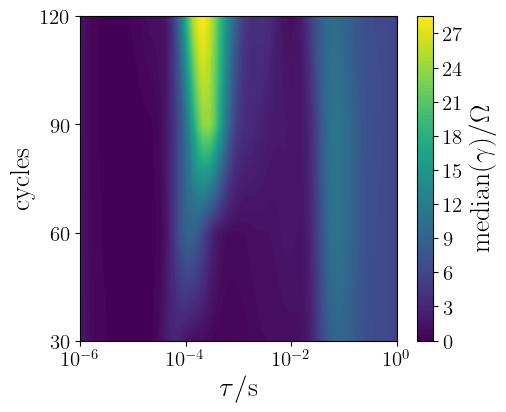

In [17]:
# experimental state
cycles = ["30", "60", "90", "120"]

# create a 2D contour plot 
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(np.log10(tau_vecs[0]), range(len(gamma_median)), np.array(gamma_median), cmap='viridis', levels=100)

# customize the axes and labels
ax.set_xlabel(r'$\tau/\mathrm{s}$', fontsize=20)
ax.set_yticks(range(len(cycles)))
ax.set_yticklabels(cycles)
ax.set_ylabel(r'$\rm cycles$', fontsize=20)

tau_ticks = [-8, -4.67, -1.34, 1.99]
tau_labels = [r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$']
ax.set_xticks(tau_ticks)
ax.set_xticklabels(tau_labels)

# add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label(r'$\rm median(\gamma)/\Omega$', fontsize=20)

plt.tight_layout()
fig = plt.gcf()

fig.set_size_inches(4.472, 4)

plt.show()

